This notebook discusses supernova nucleosynthesis in a simple core-collapse supernova model via Jupyter technology.  As you read through the text, you can execute the code blocks.  You can change input (for example, choose different axis ranges or scaling or select different species to show in the plots).  You can right-click or control-click on figures to save them.  If your current version gets corrupted, don't worry.  Simply quit and download a new copy from GitHub, or start up a new version on Google Colab.

## Table of Contents:

[Introduction](#introduction)<br/>
[Preliminaries](#preliminaries)<br/>
[The explosion and explosive yields](#explosion)<br/>
[Evolution of individual yields](#individual)<br/>

<a id='introduction'></a>
# Introduction

Here is some text to introduce the problem.

<a id='preliminaries'></a>
# Preliminaries

It is first necessary to take care of a few preliminaries.  First, install [wnutils](wnutils.readthedocs.io), the package for reading and analyzing the data.

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnutils

distutils: /Users/bradleymeyer/Library/Python/3.7/include/python3.7m/UNKNOWN
sysconfig: /Users/bradleymeyer/Library/Python/3.7/include/UNKNOWN
user = True
home = None
root = None
prefix = None


Now import the necessary packages.

In [2]:
import wnutils.xml as wx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML

<a id='explosion'></a>
# The explosion and explosive yields

This first section explores the explosion and the explosive yields.  First, retrieve the data.

In [3]:
url='file://Users/bradleymeyer/Desktop/work/jupyter-notebooks/Notebooks/snII/full_s25_pre.xml'

Store the data in a wnutils XML object.

In [4]:
xml = wx.Xml(url)

We now wish to study the supernova shock.  The model solves the Rankine-Hugoniot shock jump conditions given the initial temperature, density, and composition of the pre-supernova stellar model.  In order to close the equations, the model assumes the shocked material is a uniform pressure, photon-dominated ball with energy equal to the shock energy.  This cell extracts the parameters showing the shock evolution with time.

In [5]:
props = xml.get_properties_as_floats(['shock time', 't9_0', 'shock t9', 'mass below', 'shock rho', 'rho_0', 'mass'])

sorted_index = np.argsort( props['mass below'] )

mr = np.array(props['mass below'][sorted_index]) / 1.9891e33     # Scale to solar
mass = np.array(props['mass'][sorted_index]) / 1.9891e33     # Scale to solar
t9_0 = props['t9_0'][sorted_index]
rho_0 = props['rho_0'][sorted_index]
shock_t9 = props['shock t9'][sorted_index]
shock_rho = props['shock rho'][sorted_index]
times = props['shock time'][sorted_index]

np.insert(times, 0, 0.)

step_t9 = np.empty( (len(times),len(t9_0)) )
step_rho = np.empty( (len(times),len(t9_0)) )

for i in range(0, len(times)):
    for j in range(0, len(times)):
        if( times[j] <= times[i] and i != 0 ):
            step_t9[i,j] = shock_t9[i]
            step_rho[i,j] = shock_t9[i]
        else:
            step_t9[i,j] = t9_0[j]
            step_rho[i,j] = rho_0[j]

We now define a cell to generate frames for a movie of shock.

In [6]:
def updatefig(i, y, fonsize, yscale, xlim, ylim):
    ax.cla()
    title_str = 'time (s) = %8.2e' % times[i]
    ax.plot( mr, y[i,:] )
    ax.set_title( title_str, fontsize = fontsize)
    ax.set_yscale(yscale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel( '$M_r (M_\odot)$')
    ax.set_ylabel( '$T_9$')
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)

Create the shock movie.  Adjust the plot parameters as desired.  The default is not to create the movie since it takes several minutes to generate it.  When you are ready to generate the movie, change *b_movie* from *False* to *True* and execute the cell.

On the output movie display, use the control bar to adjust the playback of the movie (for example, the + increases the speed with which the movie is displayed).

In [7]:
b_movie = False

if b_movie:
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = 20
    yscale = 'log'
    xlim = [0, 15]
    ylim = [1.e-6, 20]
    args = (step_t9, fontsize, yscale, xlim, ylim)
    anim = animation.FuncAnimation(fig, updatefig, fargs = args, frames=len(times), blit=False)
    plt.close()
    HTML(anim.to_jshtml())

Now explore the post-explosion yields ($10^6$ seconds after the explosion).  First, select the species and create the appropriate latex names list.

In [8]:
species = ['h1', 'he4', 'c12', 'o16', 'ca48']
lnames = xml.get_latex_names(species)

Now, plot the species.  Adjust the plot parameters to your purposes.

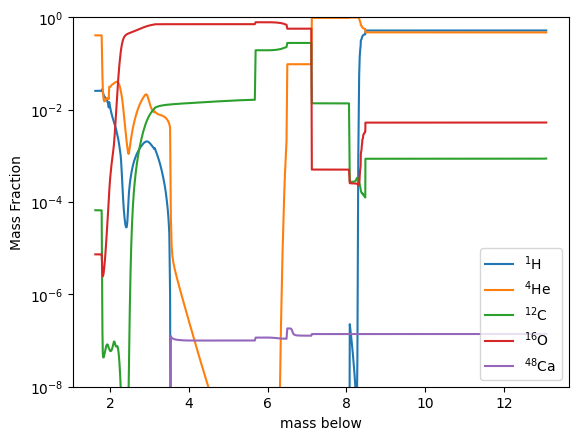

In [9]:
xml.plot_mass_fractions_vs_property('mass below', species, yscale = 'log', xfactor = 1.9891e33,
                                   use_latex_names = True, ylim = [1.e-8, 1])

Now print out the total ejected mass of each species.

In [10]:
x = xml.get_mass_fractions(species)
ejected_mass = {}

for sp in species:
    ejected_mass[sp] = 0
    
for i in range(len(mass)):
    for sp in species:
        ejected_mass[sp] += mass[i] * x[sp][i]
        
for sp in species:
    print('Ejected mass of ' + sp + ' = ' + '{:.2e}'.format(ejected_mass[sp]) + ' solar masses')

Ejected mass of h1 = 2.42e+00 solar masses
Ejected mass of he4 = 3.57e+00 solar masses
Ejected mass of c12 = 3.87e-01 solar masses
Ejected mass of o16 = 3.25e+00 solar masses
Ejected mass of ca48 = 1.22e-06 solar masses


Now print out the ejected mass fractions as a function of mass coordinate. The data are also saved in *my_file*. Change the name from the default *my_yields.txt* according to your purposes. The file will be written in the local directory. On Google Colab, click on the file tab on the far left and download.

In [11]:
my_file = 'my_yields.txt'

x = xml.get_mass_fractions(species)
f = open(my_file, 'w')

str = 'Mr\t' + 'dM\t' + '\t'.join(species)
print(str)
f.write(str + '\n')

for i in range(len(mr)):
    xx = []
    for sp in x:
        xx.append('{:.4e}'.format(x[sp][i]))
        
    str = '{:.4e}'.format(mr[i]) + '\t' + '{:.4e}'.format(mass[i])+ '\t' + '\t'.join(xx)
    print(str)
    f.write(str + '\n')
    
f.close()
    

Mr	dM	h1	he4	c12	o16	ca48
1.6188e+00	1.0055e-02	2.5345e-02	4.0328e-01	6.6079e-05	7.3338e-06	0.0000e+00
1.6289e+00	1.0055e-02	2.5346e-02	4.0327e-01	6.6073e-05	7.3329e-06	0.0000e+00
1.6389e+00	1.0055e-02	2.5348e-02	4.0328e-01	6.6074e-05	7.3331e-06	0.0000e+00
1.6490e+00	1.0055e-02	2.5351e-02	4.0329e-01	6.6068e-05	7.3316e-06	0.0000e+00
1.6590e+00	1.0055e-02	2.5355e-02	4.0329e-01	6.6061e-05	7.3306e-06	0.0000e+00
1.6691e+00	1.0055e-02	2.5361e-02	4.0330e-01	6.6051e-05	7.3289e-06	0.0000e+00
1.6792e+00	1.0055e-02	2.5368e-02	4.0331e-01	6.6036e-05	7.3261e-06	0.0000e+00
1.6892e+00	1.0055e-02	2.5386e-02	4.0334e-01	6.6004e-05	7.3187e-06	0.0000e+00
1.6993e+00	1.0055e-02	2.5391e-02	4.0334e-01	6.5995e-05	7.3184e-06	0.0000e+00
1.7093e+00	1.0055e-02	2.5396e-02	4.0335e-01	6.5986e-05	7.3164e-06	0.0000e+00
1.7194e+00	1.0055e-02	2.5400e-02	4.0335e-01	6.5979e-05	7.3155e-06	0.0000e+00
1.7294e+00	1.0055e-02	2.5404e-02	4.0336e-01	6.5972e-05	7.3142e-06	0.0000e+00
1.7395e+00	1.0055e-02	2.5406e-02	4.0338e-01	6.5972

<a id='individual'></a>
# Evolution of individual zones

We now look at the time evolution of properties of individual zones in the explosion.  First, choose a zone to explore by the index.

In [12]:
zone_index = 300

zone_xpath = '[position() = ' + '{:d}'.format(zone_index - 1) + ']'
zone_data = xml.get_zone_data(zone_xpath)
zone_label = (list(zone_data.keys()))[0]
print('The zone you have chosen has mass coordinate', '{:.2f}'.format(mr[zone_index]), 'solar masses.')
print('It has label', zone_label, '.')
zone_xml = wx.Xml(...)

The zone you have chosen has mass coordinate 6.14 solar masses.
It has label 470 .


TypeError: cannot parse from 'ellipsis'

Plot a property in the zone as a function of time.

In [ ]:
zone_xml.plot_property_vs_property('time', 't9', xscale = 'log', yscale = 'linear')

Choose species to follow.

In [ ]:
zone_species = ['he4', 'mo96']
lnames = zone_xml.get_latex_names(zone_species)

In [ ]:
zone_xml.plot_mass_fractions_vs_propery('time', species', xscale = 'log', yscale = 'log', xlabel = 'time (s)',
                                       use_latex_names = True)

Now print out the mass fractions in the zone as a function of a chosen property. The data are also saved in my_file. Change the name from the default my_x_vs_prop.txt according to your purposes. The file will be written in the local directory. On Google Colab, click on the file tab on the far left and download.

In [ ]:
my_file = 'my_x_vs_prop.txt'

property = 'time'
x = zone_xml.get_mass_fractions(species)
props = zone_xml.get_properties([property])

f = open(my_file, 'w')

str = property + '\t' + '\t'.join(species)
print(str)
f.write(str + '\n')

for i in range(len(props[property])):
    xx = []
    for sp in x:
        xx.append('{:.4e}'.format(x[sp][i]))
        
    str = '{:.4e}'.format(props[property][i]) + '\t' + '{:.4e}'.format(mass[i])+ '\t' + '\t'.join(xx)
    print(str)
    f.write(str + '\n')
    
f.close()